# Project: File Ingestion ans Schema Validation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task" data-toc-modified-id="Task-1">Task</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2">Import modules</a></span></li><li><span><a href="#Read-YAML-config-file" data-toc-modified-id="Read-YAML-config-file-3">Read YAML config file</a></span></li><li><span><a href="#Compare-different-approaches-of-reading-file" data-toc-modified-id="Compare-different-approaches-of-reading-file-4">Compare different approaches of reading file</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Pandas" data-toc-modified-id="Pandas-4.0.1">Pandas</a></span></li><li><span><a href="#Dask" data-toc-modified-id="Dask-4.0.2">Dask</a></span></li><li><span><a href="#Ray" data-toc-modified-id="Ray-4.0.3">Ray</a></span></li><li><span><a href="#Modin" data-toc-modified-id="Modin-4.0.4">Modin</a></span></li></ul></li><li><span><a href="#Compare-results" data-toc-modified-id="Compare-results-4.1">Compare results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.2">Conclusion</a></span></li></ul></li></ul></div>

## Task 

* Compare different approaches of reading large csv file

## Import modules

In [44]:
from time import time
import utility
import warnings
import dask.dataframe as dd
import pandas as pd
import ray
import modin.pandas as mpd
import os
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Read YAML config file

In [2]:
config = utility.read_config_file('file.yaml')

In [3]:
config

{'file_type': 'csv',
 'dataset_name': 'commerce',
 'file_name': 'commerce',
 'table_name': 'commercesurv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'columns': ['event_time',
  'event_type',
  'product_id',
  'category_id',
  'category_code',
  'brand',
  'price',
  'user_id',
  'user_session']}

## Compare different approaches of reading file 

In [4]:
file_name = config['file_name']
file_type = config['file_type']
file = file_name + f'.{file_type}'

delimiter = config['inbound_delimiter']

#### Pandas

In [5]:
start = time()
pd.read_csv(file, delimiter=delimiter)
end = time()

pandas_time = end - start

#### Dask

In [6]:
start = time()
dd.read_csv(file, delimiter=delimiter)
end = time()

dask_time = end - start

#### Ray

In [7]:
start = time()
ray.data.read_csv(file, delimiter=delimiter)
end = time()

ray_time = end - start

2023-04-09 12:43:56,256	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2023-04-09 12:43:58,096	WARNING read_api.py:319 -- ⚠️  The blocks of this dataset are estimated to be 10.0x larger than the target block size of 512 MiB. This may lead to out-of-memory errors during processing. Consider reducing the size of input files or using `.repartition(n)` to increase the number of dataset blocks.


#### Modin

- Modin on `Ray`

In [8]:
os.environ["MODIN_ENGINE"] = "ray" 

In [9]:
start = time()
mpd.read_csv(file, delimiter=delimiter)
end = time()

mpd_on_ray_time = end - start

2023-04-09 12:44:20,763	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: d3e9093e562ecc172aaaee097d9f6624b6ca128501000000 Worker ID: 0f7ed7de003bfdccb9442f2356f000874b277ee23af59e4b57cc8087 Node ID: cdb4f018d4108a322401067e104a5a2510eb8c1008280254d32d9988 Worker IP address: 172.20.10.8 Worker port: 41003 Worker PID: 6227 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


- Modin on `Dask`

In [10]:
os.environ["MODIN_ENGINE"] = "dask" 

In [11]:
start = time()
mpd.read_csv(file, delimiter=delimiter)
end = time()

mpd_on_dask_time = end - start

2023-04-09 12:44:54,751	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 1856a5a3b3c8b5e55000f0db7883fce6763a6e2a01000000 Worker ID: 9bc34265a9ebb5faf17ebf81b9f58e70a1b13218658e7d352dabd22a Node ID: cdb4f018d4108a322401067e104a5a2510eb8c1008280254d32d9988 Worker IP address: 172.20.10.8 Worker port: 40115 Worker PID: 6936 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned.
(raylet) [2023-04-09 12:45:00,341 E 6133 6133] (raylet) node_manager.cc:3040: 7 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: cdb4f018d4108a322401067e104a5a2510eb8c1008280254d32d9988, IP: 172.20.10.8) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 

- Modin on `Unidist`

In [12]:
os.environ["MODIN_ENGINE"] = "unidist"

In [13]:
start = time()
mpd.read_csv(file, delimiter=delimiter)
end = time()

mpd_on_unidist_time = end - start

2023-04-09 12:45:30,623	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 4e87d5e805a620057db8c106f8727be84114af3701000000 Worker ID: 17d965a37344f1a73a7de4150352f0b6f63d3ea2794dd993d55b9a65 Node ID: cdb4f018d4108a322401067e104a5a2510eb8c1008280254d32d9988 Worker IP address: 172.20.10.8 Worker port: 33583 Worker PID: 7584 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
2023-04-09 12:45:34,717	WARNING worker.py:1866 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead w

### Compare results

In [21]:
data = {'Framework':['Pandas', 
                     'Dask', 
                     'Ray', 
                     'Modin on Dask', 
                     'Modin on Ray', 
                     'Modin on Unidist'],
        'Time, sec':[pandas_time, 
                     dask_time, 
                     ray_time, 
                     mpd_on_dask_time, 
                     mpd_on_ray_time, 
                     mpd_on_unidist_time]
       }

results_df = pd.DataFrame.from_dict(data).sort_values(by='Time, sec').round(3)
results_df

,Framework,"Time, sec"
1,Dask,0.016
2,Ray,4.672
4,Modin on Ray,32.143
5,Modin on Unidist,33.359
3,Modin on Dask,40.519
0,Pandas,46.462


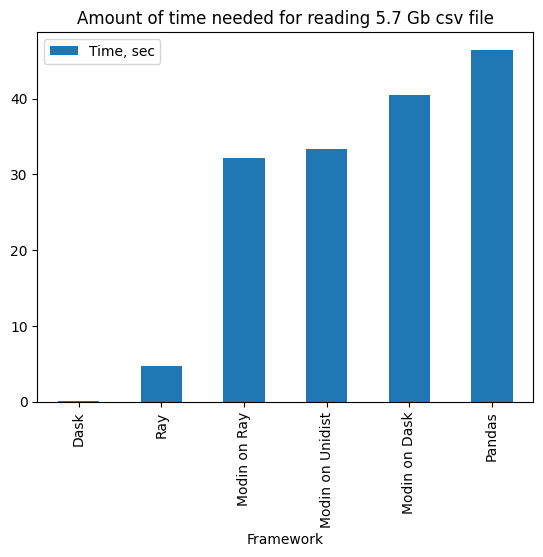

,Framework,"Time, sec"
1,Dask,0.016
2,Ray,4.672
4,Modin on Ray,32.143
5,Modin on Unidist,33.359
3,Modin on Dask,40.519
0,Pandas,46.462


In [30]:
results_df.plot(x='Framework', 
                y='Time, sec', 
                kind='bar',
                title='Amount of time needed for reading 5.7 Gb csv file'
               )
plt.show()
display(results_df)

### Conclusion

- From the results above we can see that `Dask` framework is by far quicker than others in terms of reading ~6 Gb csv file